<img src="ost_logo.png" width="240" height="240" align="right"/>
<div style="text-align: left"> <b> Machine Learning </b> <br> MSE FTP MachLe <br> 
<a href="mailto:christoph.wuersch@ost.ch"> Christoph Würsch </a> </div>

# Lab 6, A2 Feature Selection on the Wisconsin Breast Cancer Dataset

In [1]:
import matplotlib_inline
%matplotlib inline
#from preamble import *

from IPython.display import set_matplotlib_formats, display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

matplotlib_inline.backend_inline.set_matplotlib_formats('pdf', 'png')
plt.rcParams['figure.dpi'] = 300
plt.rcParams['image.cmap'] = "viridis"
plt.rcParams['image.interpolation'] = "none"
plt.rcParams['savefig.bbox'] = "tight"
plt.rcParams['lines.linewidth'] = 2

from sklearn.datasets import load_breast_cancer
from sklearn.feature_selection import SelectPercentile
from sklearn.model_selection import train_test_split

cancer = load_breast_cancer()
print(cancer.target_names)
print(cancer.feature_names)


['malignant' 'benign']
['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']


### (a) Plotting Histograms

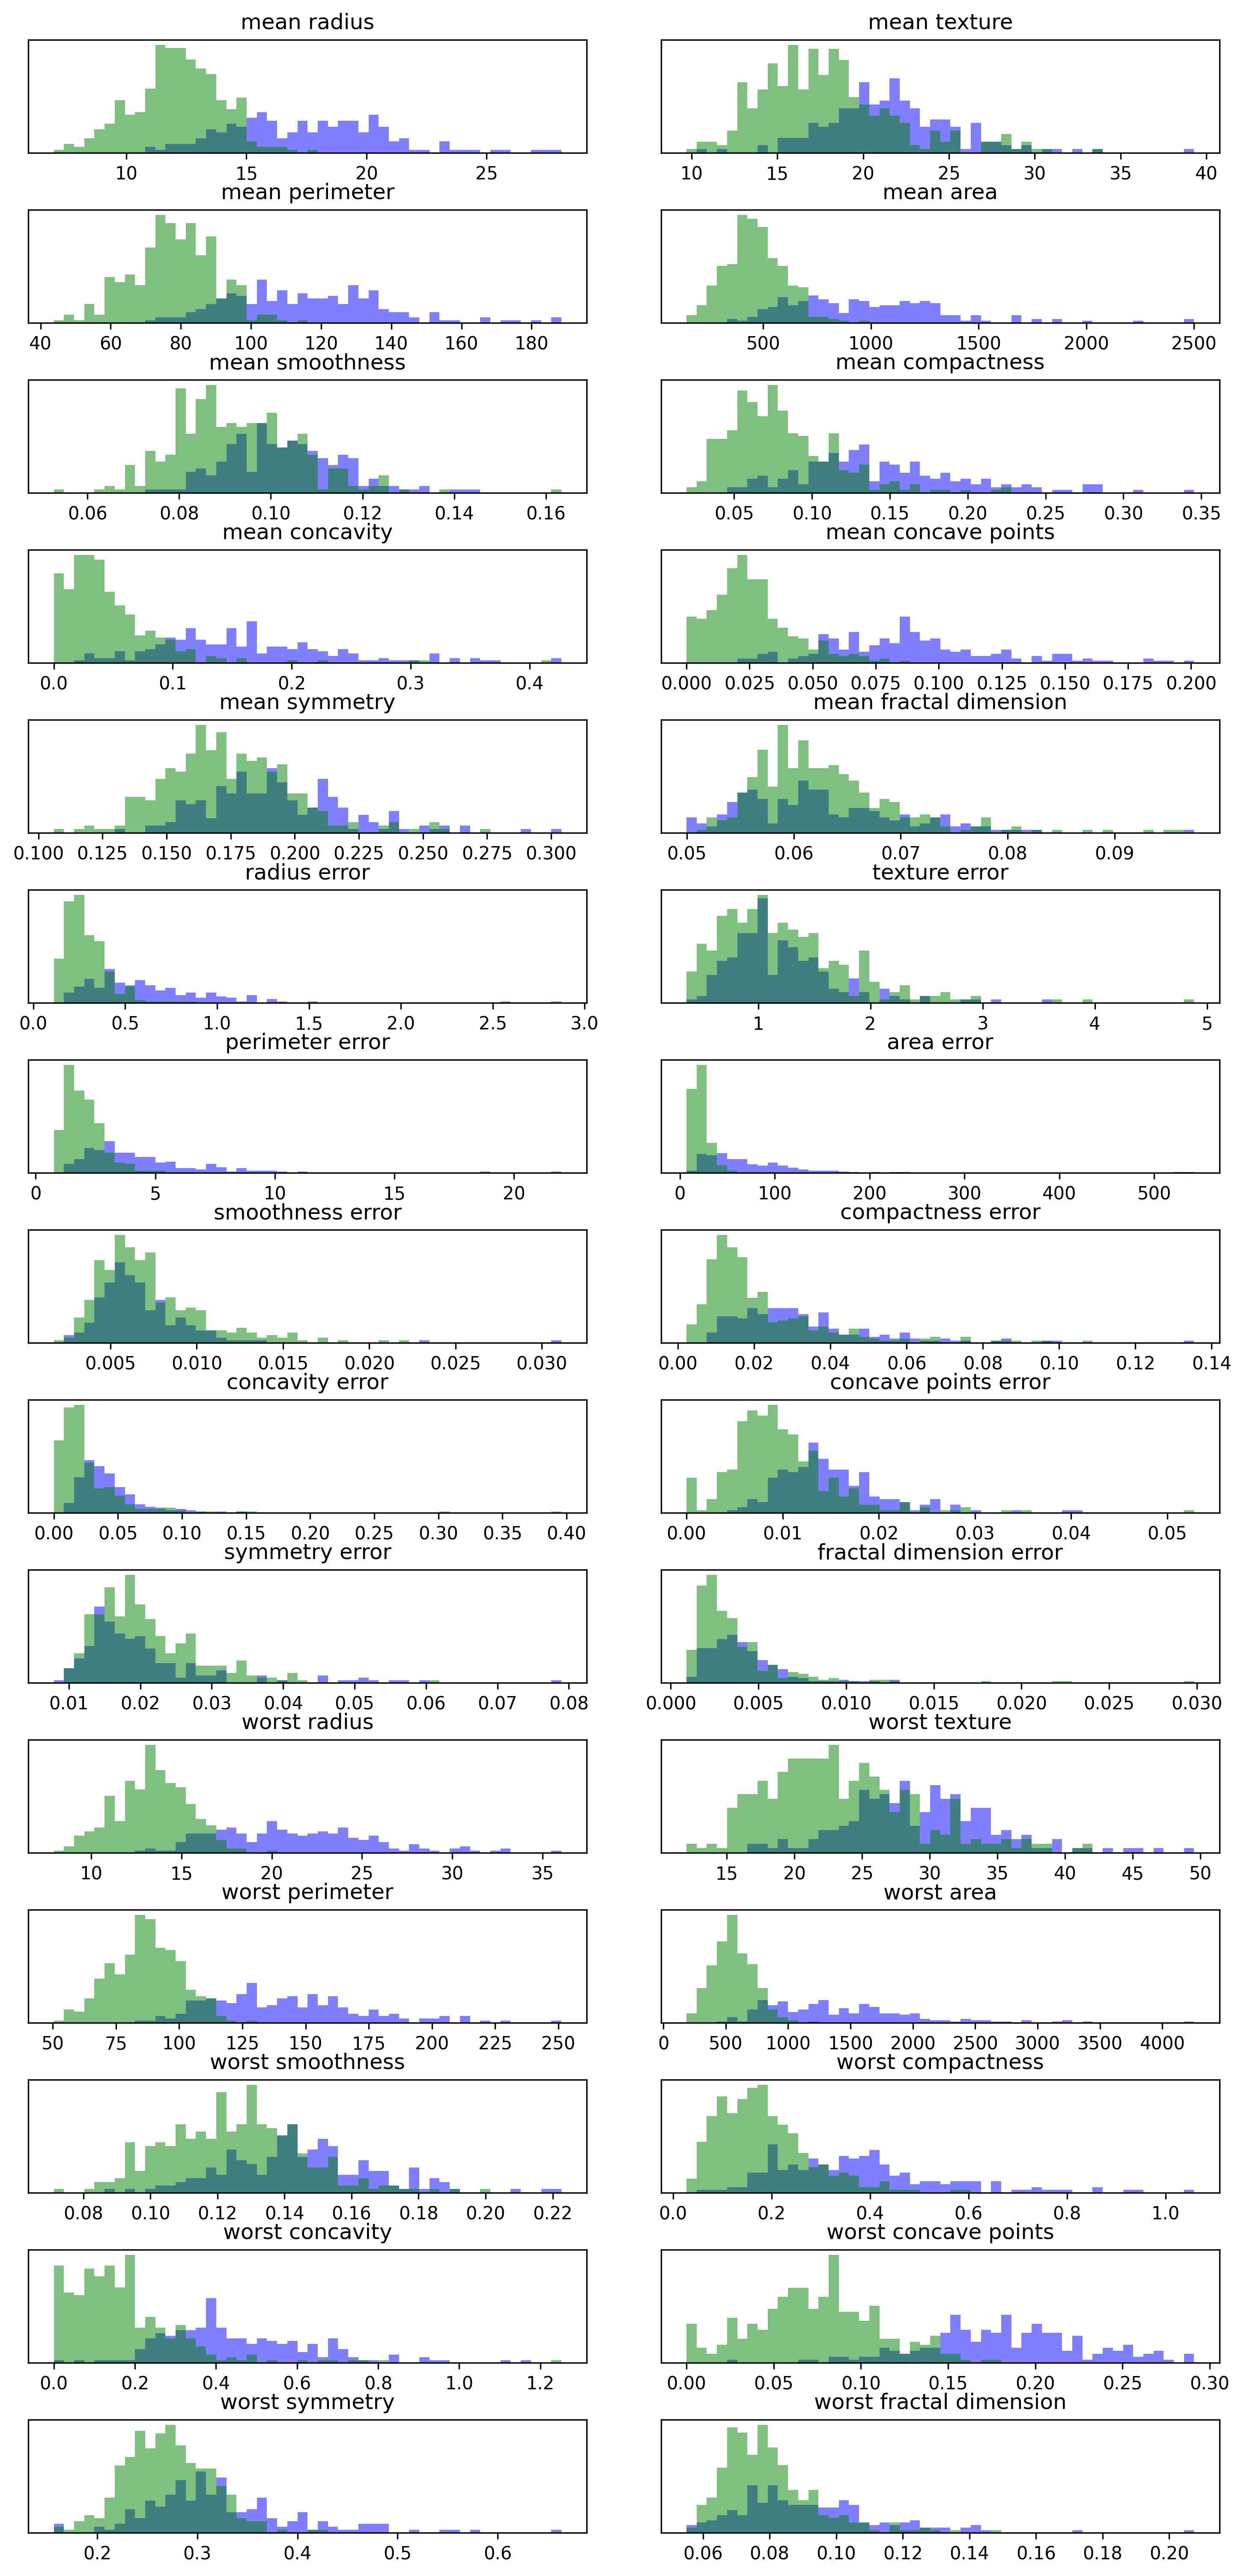

In [7]:
fig, axes = plt.subplots(15, 2, figsize=(10, 20))
fig.tight_layout()
malignant = cancer.data[cancer.target == 0]
benign = cancer.data[cancer.target == 1]
ax = axes.ravel()
for i in range(30):
    _, bins = np.histogram(cancer.data[:, i], bins=50)
    ax[i].hist(malignant[:, i], bins=bins, color='b', alpha=.5)
    ax[i].hist(benign[:, i], bins=bins, color='g', alpha=.5)
    ax[i].set_title(cancer.feature_names[i])
    ax[i].set_yticks(())

    # ax[0].set_xlabel("Größe des Merkmals")

### (b) Automatic Feature Selection: Univariate statistics (F-test, ANOVA)

In [9]:

X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=0, test_size=.5)
# use f_classif (the default) and SelectPercentile to select 50% of features
select = SelectPercentile(percentile=50)
select.fit(X_train, y_train)
# transform training set
X_train_selected = select.transform(X_train)

print("X_train.shape: {}".format(X_train.shape))
print("X_train_selected.shape: {}".format(X_train_selected.shape))

X_train.shape: (284, 30)
X_train_selected.shape: (284, 15)


[ True False  True  True False  True  True  True False False  True False
  True  True False False False False False False  True False  True  True
 False  True  True  True False False]


([], [])

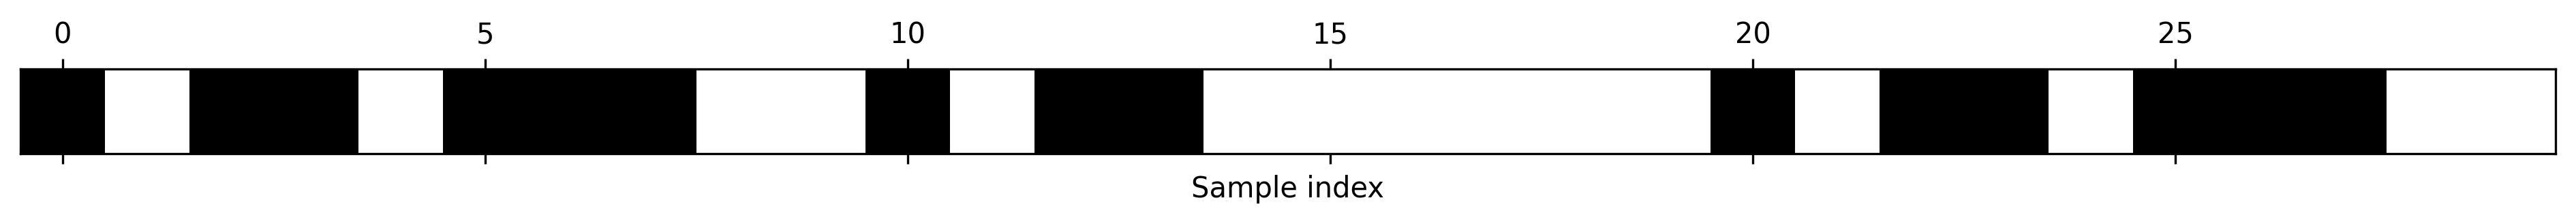

In [10]:
mask = select.get_support()
print(mask)
# visualize the mask. black is True, white is False
plt.matshow(mask.reshape(1, -1), cmap='gray_r')
plt.xlabel("Sample index")
plt.yticks(())

<BarContainer object of 30 artists>

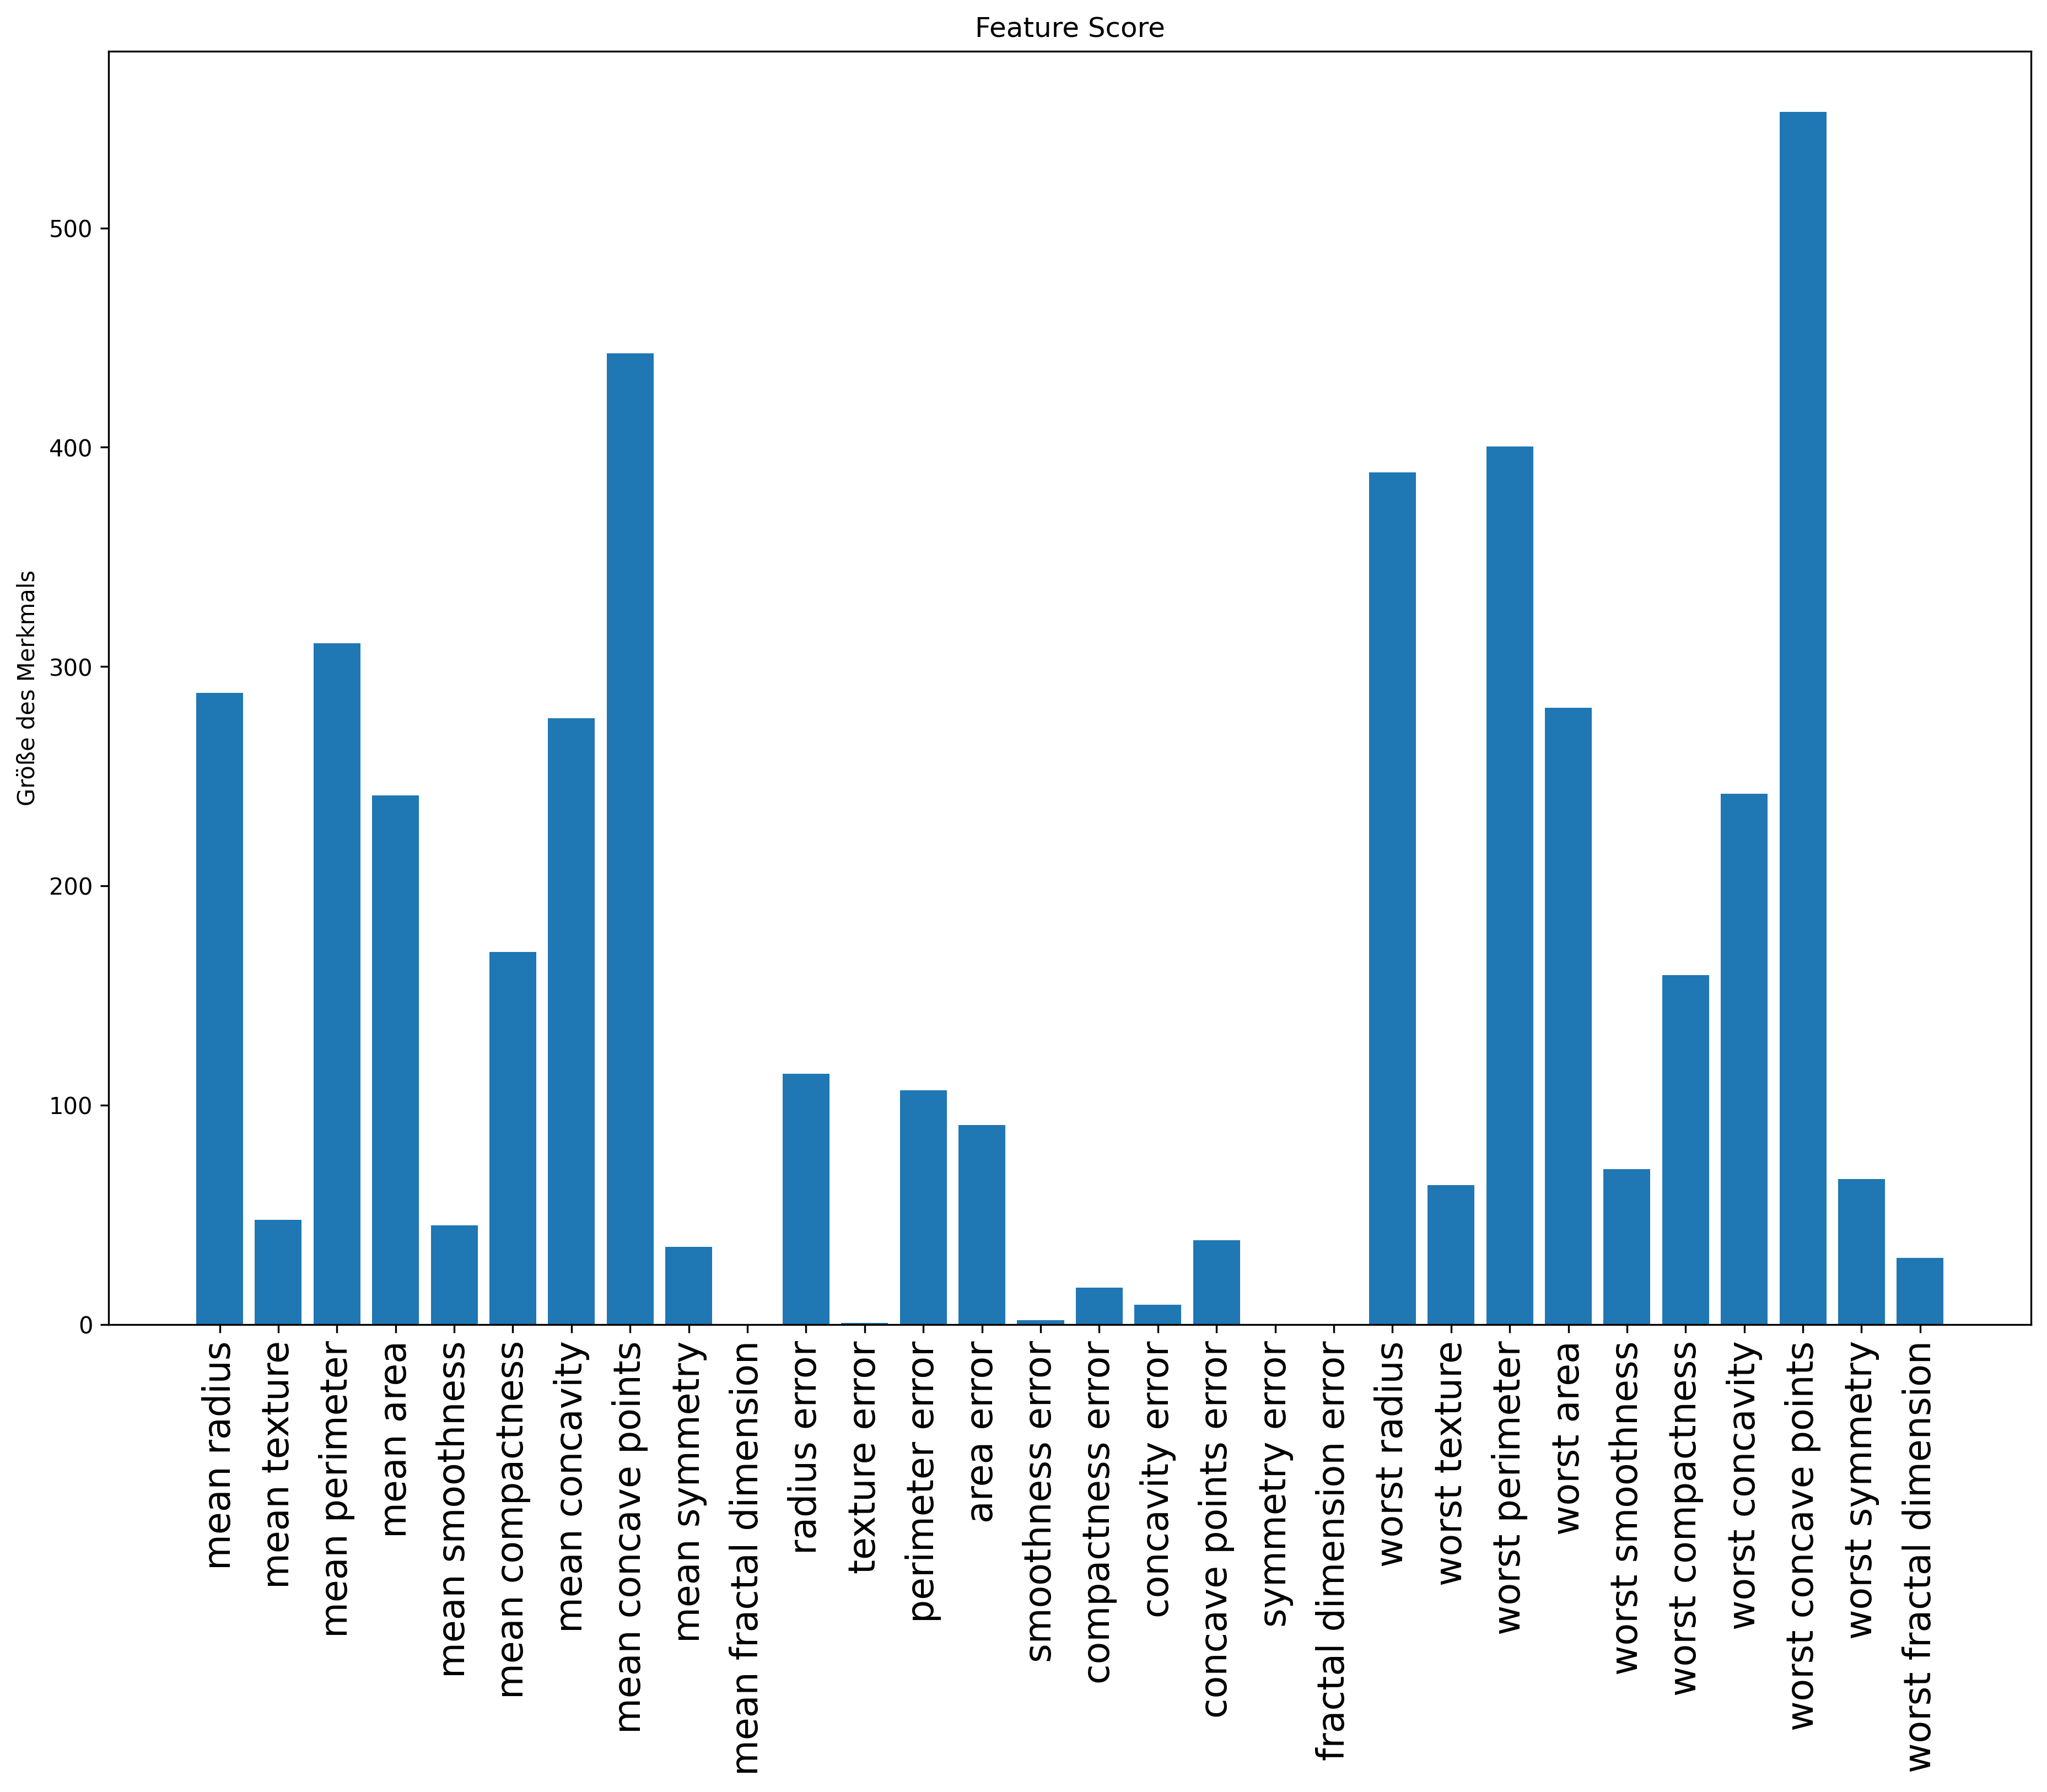

In [11]:

# visualize the mask. black is True, white is False
plt.figure(figsize=(15, 10))
n_features = cancer.data.shape[1]
plt.title("Feature Score")
plt.xticks(np.arange(n_features), cancer.feature_names, rotation=90, fontsize=16)
plt.ylabel("Größe des Merkmals")
plt.bar(range(n_features), select.scores_)

In [12]:
mask.reshape(1, -1)

array([[ True, False,  True,  True, False,  True,  True,  True, False,
        False,  True, False,  True,  True, False, False, False, False,
        False, False,  True, False,  True,  True, False,  True,  True,
         True, False, False]])

Let's fit now a linear model (logistic regression) model on the reduced input features to check the accuracy on the reduced input features.

In [15]:
from sklearn.linear_model import LogisticRegression

# transform test data
X_test_selected = select.transform(X_test)

lr = LogisticRegression()
lr.fit(X_train, y_train)
print("Score with all features: {:.3f}".format(lr.score(X_test, y_test)))
lr.fit(X_train_selected, y_train)
print("Score with only selected features: {:.3f}".format(
    lr.score(X_test_selected, y_test)))

Score with all features: 0.954
Score with only selected features: 0.958


/Users/davebrunner/.local/share/virtualenvs/FTP_MachLe-TAxQAUJy/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/davebrunner/.local/share/virtualenvs/FTP_MachLe-TAxQAUJy/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver 

### (c) Automatic Feature selection: Model-based Feature Selection using Random Forest Classifier

A random forest classifier gives back the relative feature importance. This score can be used to select the most important featurs.

Accuracy on training set: 0.982
Accuracy on test set: 0.926
Feature importances:
[0.         0.02355646 0.         0.         0.         0.
 0.02214307 0.         0.         0.02775379 0.00513077 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.11199707 0.
 0.         0.         0.         0.80941884 0.         0.        ]


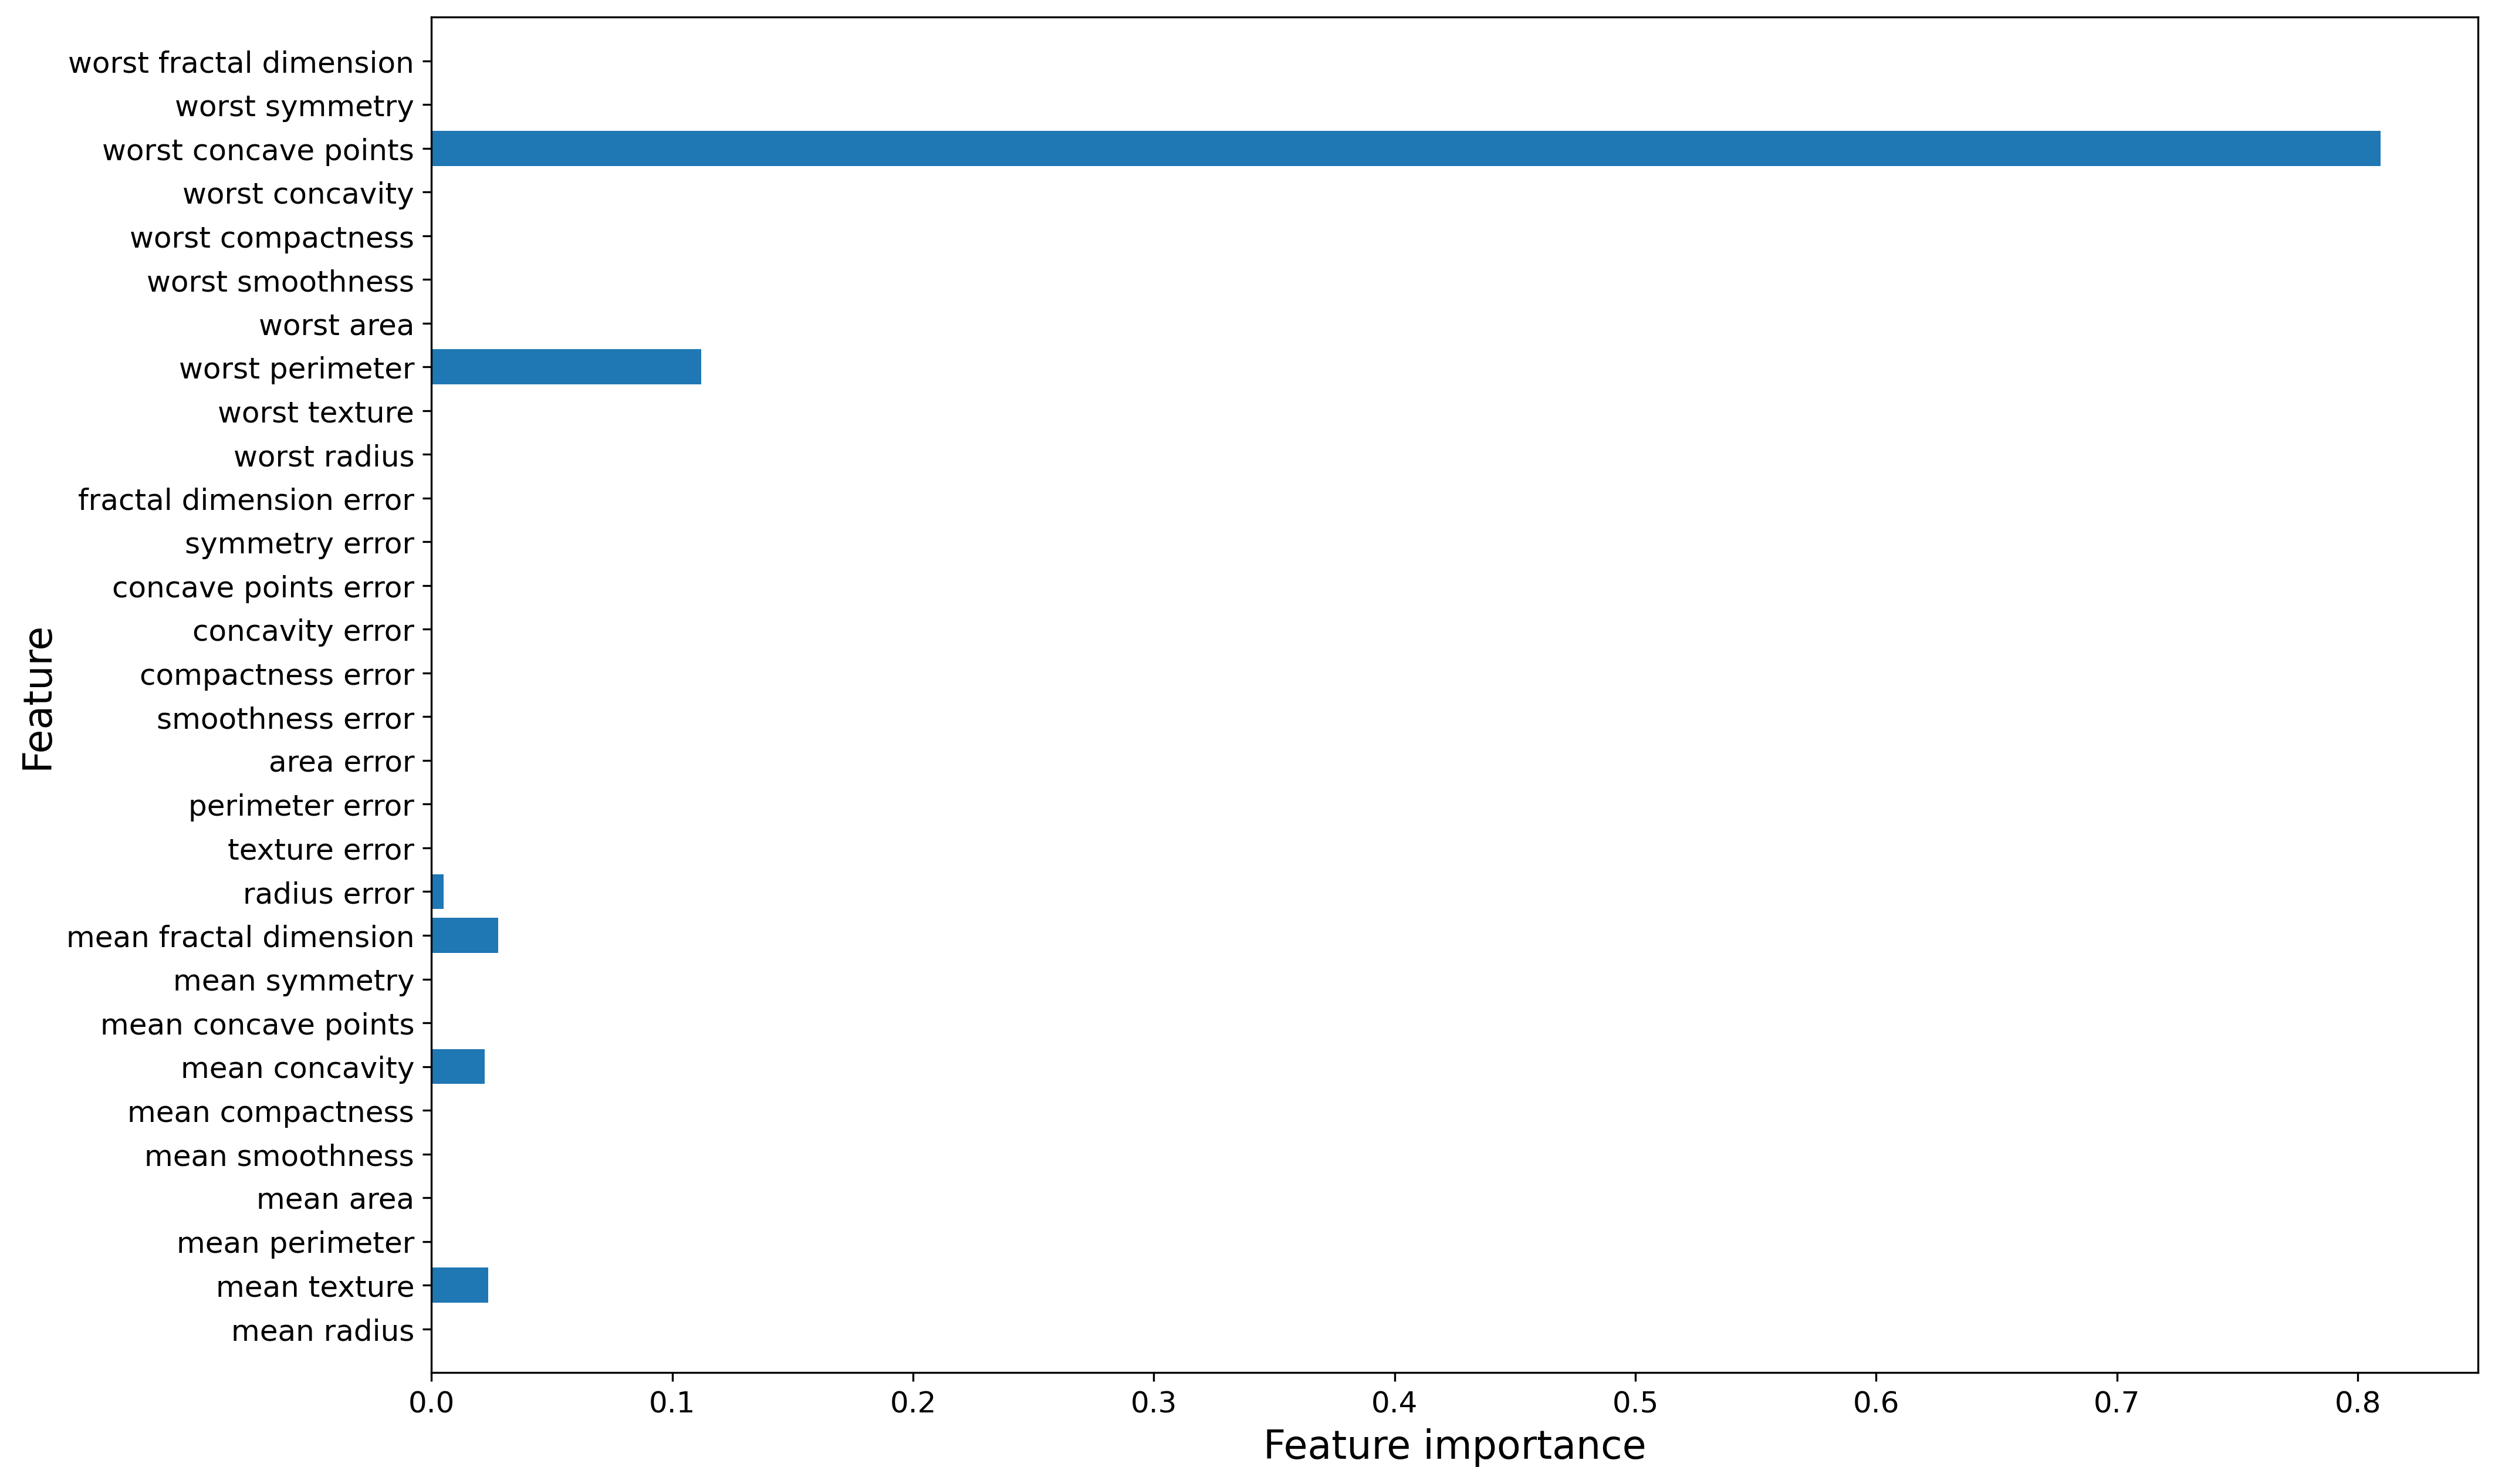

In [17]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(max_depth=4, random_state=0)
tree.fit(X_train, y_train)

print("Accuracy on training set: {:.3f}".format(tree.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(tree.score(X_test, y_test)))

print("Feature importances:\n{}".format(tree.feature_importances_))


def plot_feature_importances_cancer(model):
    plt.figure(figsize=(15, 10))
    n_features = cancer.data.shape[1]
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), cancer.feature_names, fontsize=12)
    plt.xticks(fontsize=12)

    plt.xlabel("Feature importance", fontsize=16)
    plt.ylabel("Feature", fontsize=16)
    plt.ylim(-1, n_features)


plot_feature_importances_cancer(tree)

### (d) Automatic Feature selection: Model-based Feature Selection using Random Forest Classifier


In [25]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

rfc =    RandomForestClassifier(n_estimators=100, random_state=42)
select = SelectFromModel(rfc,
    threshold="median")

In [26]:
select.fit(X_train, y_train)
X_train_l1 = select.transform(X_train)
print("X_train.shape: {}".format(X_train.shape))
print("X_train_l1.shape: {}".format(X_train_l1.shape))

X_train.shape: (284, 30)
X_train_l1.shape: (284, 15)


([], [])

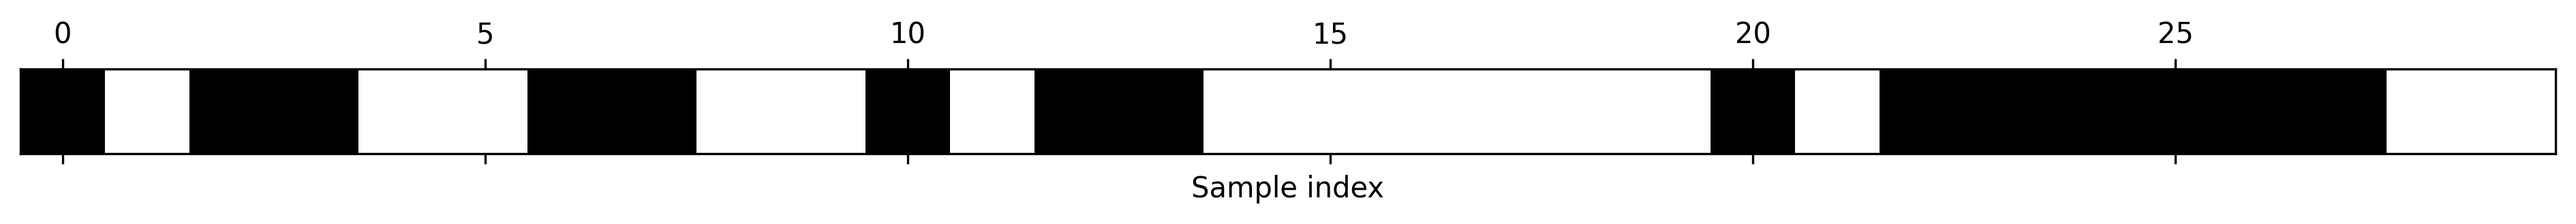

In [27]:
mask = select.get_support()
# visualize the mask. black is True, white is False
plt.matshow(mask.reshape(1, -1), cmap='gray_r')
plt.xlabel("Sample index")
plt.yticks(())

In [34]:
X_test_l1 = select.transform(X_test)
score = LogisticRegression().fit(X_train_l1, y_train).score(X_test_l1, y_test)
print("Test score: {:.3f}".format(score))

Test score: 0.958


/Users/davebrunner/.local/share/virtualenvs/FTP_MachLe-TAxQAUJy/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


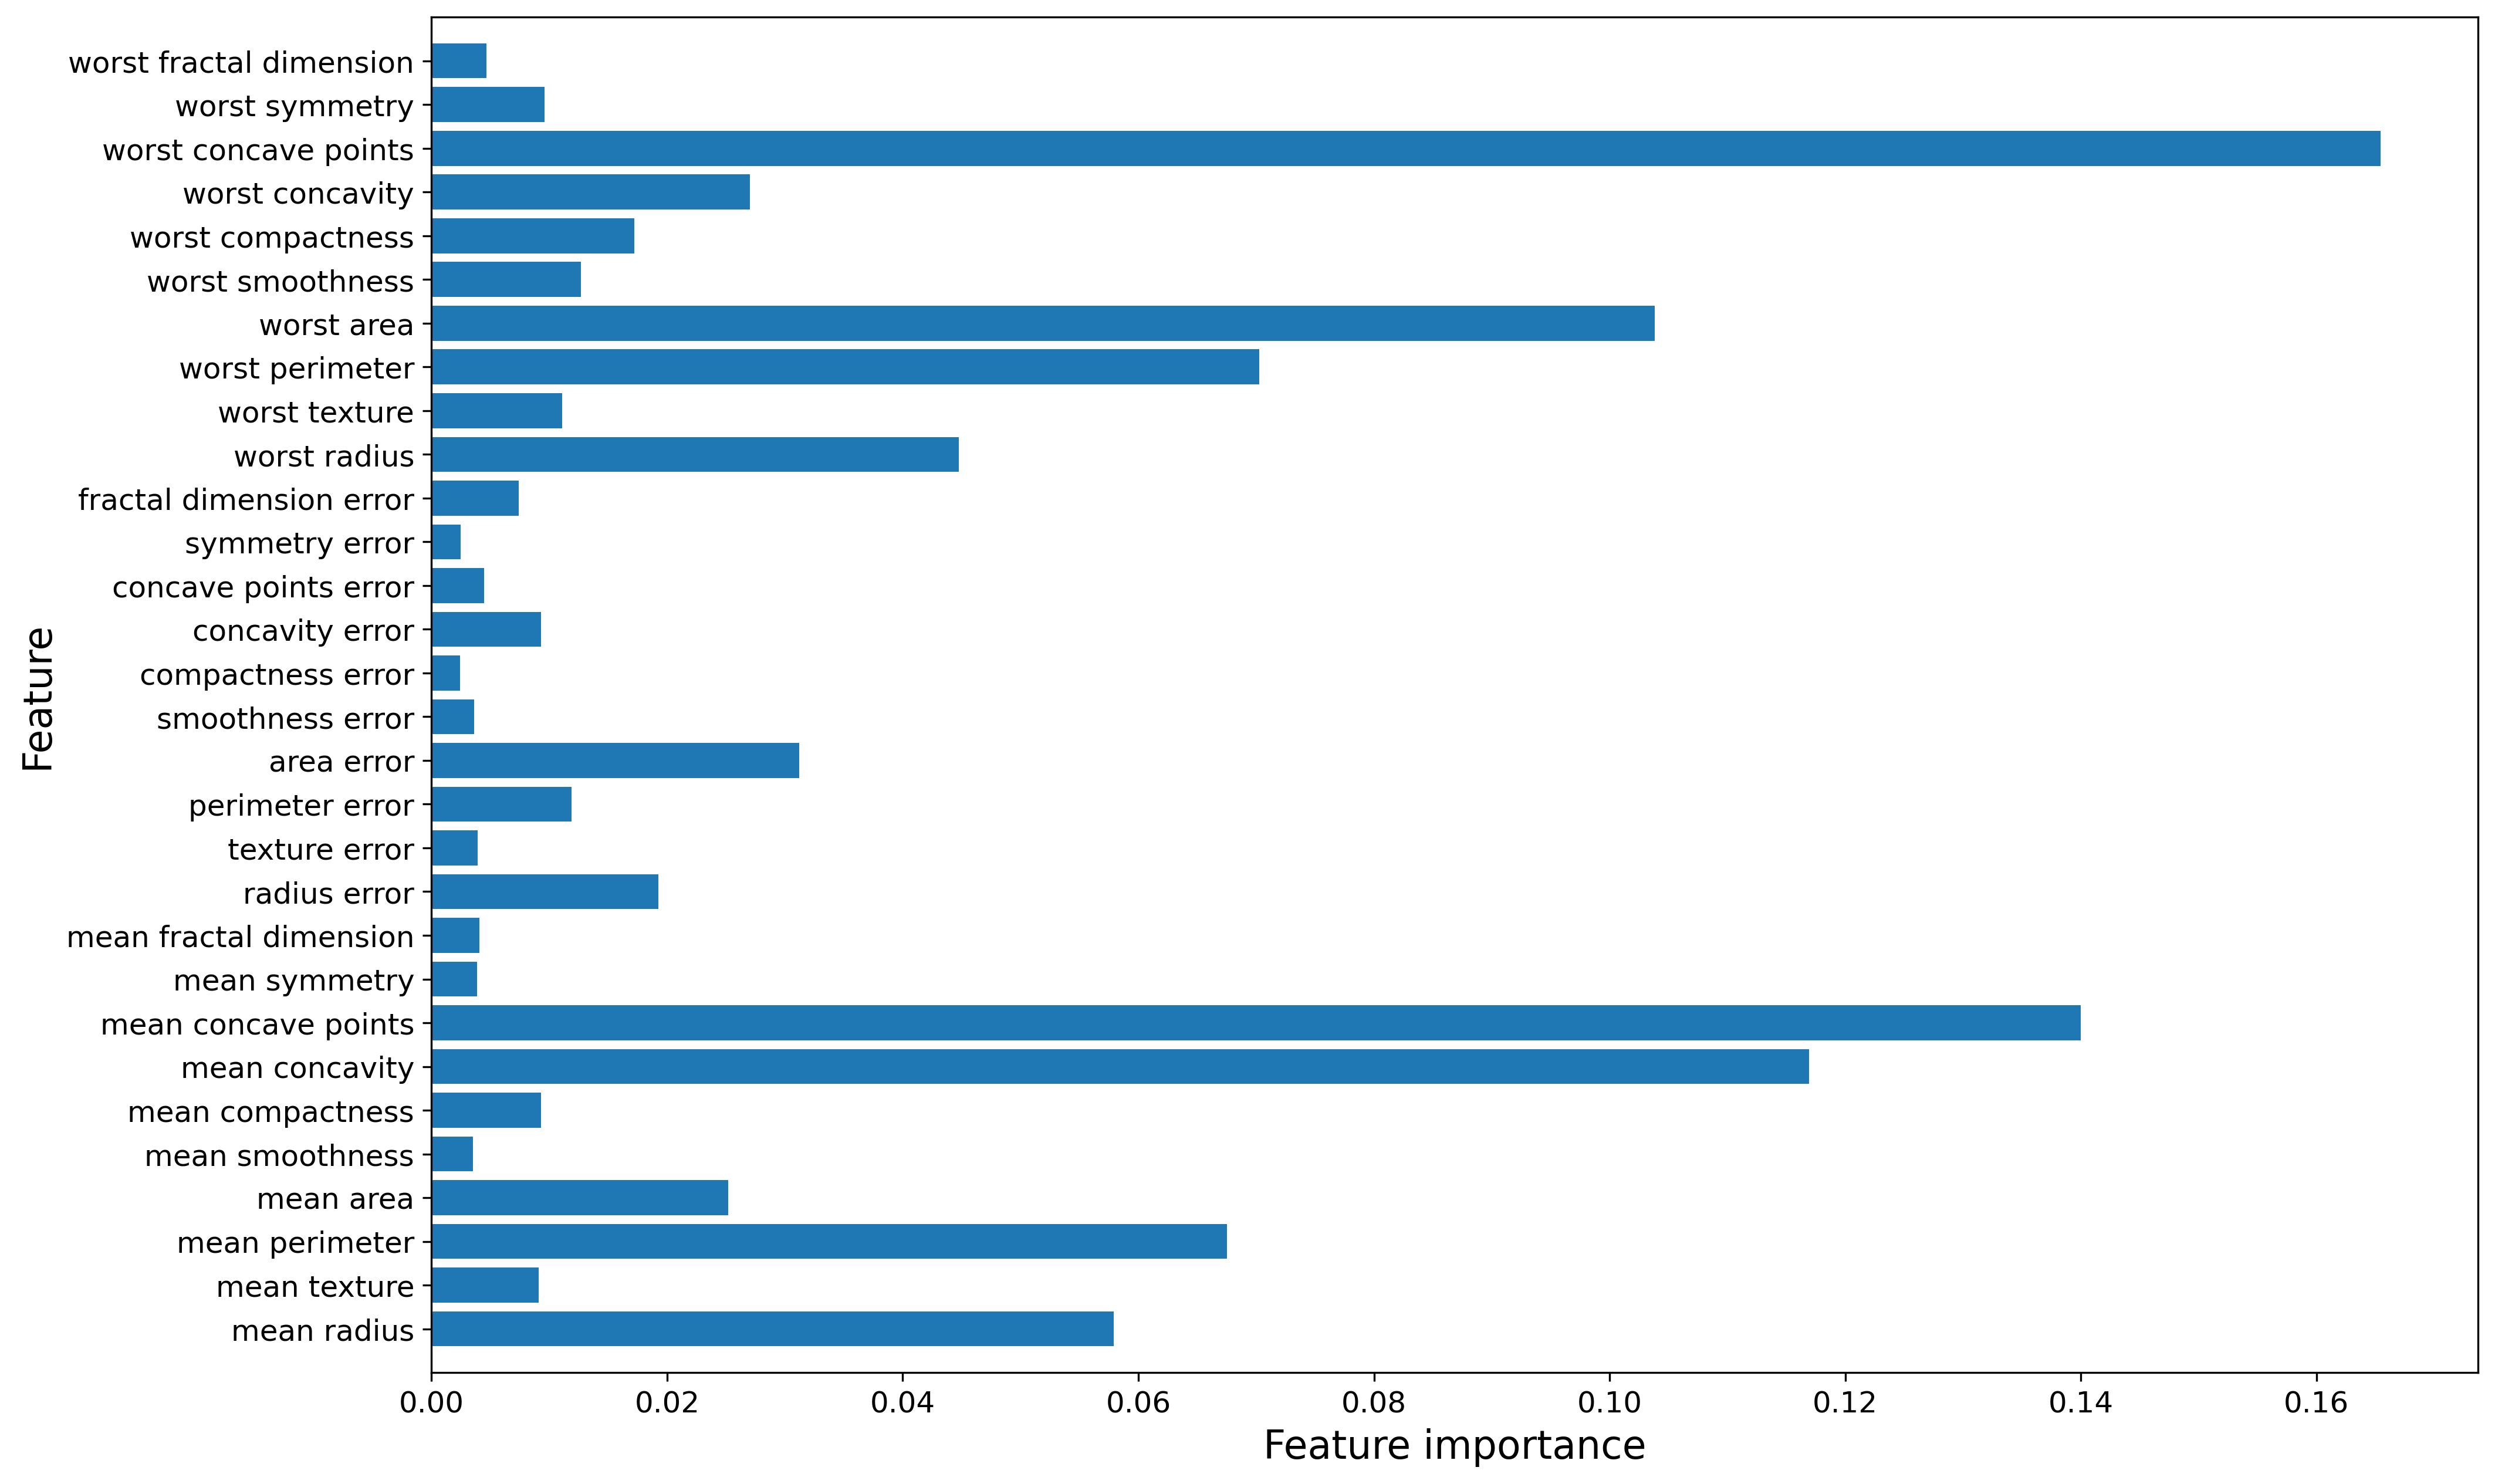

In [33]:
# Just as a reference on how a RandomForestClassifier would define the feature importance compared to the DecisionTree
rfc.fit(X_train, y_train)
plot_feature_importances_cancer(rfc)